In [1]:
from EntityResolutionEngine import EntityResolutionEngine as EntityResolutionEngine 

import main as sigmod
import similar_feature_grouping as similar_feature_grouping
import helper as helper
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gunesyurdakul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset_path="../datasets/2013_camera_specs/"

dataset_df = sigmod.create_brand_dataframe(dataset_path)
data_dict=sigmod.get_all_keys_values(dataset_path)
#ataset_df['all_features'] = dataset_df['spec_id'].apply(lambda x: data_dict[x])
#dataset_df['page_title'] =  dataset_df['all_features'].apply(lambda x: x['<page title>'])

  0%|          | 0/24 [00:00<?, ?it/s]

Creating df
>>> Creating dataframe...



  0%|          | 0/24 [00:00<?, ?it/s]

>>> Dataframe created successfully!



100%|██████████| 24/24 [00:14<00:00,  1.78it/s]


In [3]:
data_dict['www.eglobalcentral.co.uk//147']

{'<page title>': 'canon eos 7d body digital slr camera',
 'aspect ratio': '3:2 (horizontal; vertical)',
 'battery': 'lp-e6',
 'continuous shooting fps': '8',
 'dimensions w x h x d': '148.2 x 110.7 x 73.5 mm',
 'effective pixels': 'approx. 18 megapixels',
 'focal length fmm': '1.6x',
 'gps': 'optional',
 'hdmi': 'hdmi mini',
 'image processor': 'digic 4',
 'image stabilisation': '',
 'iso sensitivity': 'iso 100-6400, expandable h (equivalent iso 12800)',
 'lcd screen size inch': '3.0',
 'lens mount': 'ef mount',
 'max resolution': '5184 x 3456',
 'microphone': 'built-in monaural microphone, external stereo microphone terminal provided',
 'movie size': '1920 x 1080 1280 x 720 640 x 480',
 'sensor size': '22.3 x 14.9mm',
 'sensor type': 'cmos',
 'shutter speed': '30-1/8000 sec, bulb',
 'storage type': 'type ii cf card, udma-compatible',
 'total pixels': 'approx. 19 megapixels',
 'usb': '2.0',
 'viewfinder': 'optical, 100% coverage',
 'weight inc batteries': '900g',
 'wireless': 'optional

In [4]:
dataset_df[dataset_df['spec_id']=='www.eglobalcentral.co.uk//147']

,source,spec_number,spec_id,page_title,brand
13050,www.eglobalcentral.co.uk,147,www.eglobalcentral.co.uk//147,canon eos 7d 19mp,


In [5]:
dataset_df = sigmod.compute_brand_blocking(dataset_df)


247it [00:00, 2464.16it/s]

>>> Computing blocking...


29787it [00:07, 3794.39it/s]
29787it [00:06, 4835.14it/s]


ended
>>> Blocking computed successfully!



In [6]:
labelled_df = pd.read_csv('../datasets/sigmod_large_labelled_dataset.csv')
same_products = sigmod.grouping_same_products_from_labelled_set(labelled_df)

#They all represent the same products
len(labelled_df)

297651

In [7]:
dataset_df = dataset_df.set_index('spec_id')

In [8]:
dataset_df.to_pickle('dataset_df.pickle')

## EXTRACT MODEL NAMES

In [9]:
grouped = dataset_df.groupby('blocking_key')

In [10]:
grouped.size()

blocking_key
accessory    124
advert         1
aiptek        11
allen          1
alpha        426
            ... 
vizio         37
vtech         10
wespro         4
wildgame       1
yourdeal       9
Length: 86, dtype: int64

In [153]:
import re
models={}
for blocking_key in set(dataset_df.blocking_key):
    block_df=grouped.get_group(blocking_key)
    block_df['model']=block_df.page_title.apply(lambda x: [' '.join(x[idx:].split()[:1]) for idx in [x.start() for x in re.finditer(blocking_key+' ', x)]])
    block_df['model']=block_df['model'].apply(lambda x:x[0] if len(x)>0 else '')
    models.update(block_df.groupby('model').size().to_dict())
del models['']

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [154]:
import numpy as np
counts = np.array(list(models.values()))
limit=np.percentile(counts,50)
keys=list(models.keys()).copy()
skip_keys=['sigma','other','tamron','samsung nx','eos 5d','sony mavica','sony digital','sony ccd','hikvision ir','svp','canon ef','leica','vizio','enxun','hasselblad','disney','casio exilim']
dahua_keys = ['hdb' , 'sd6' , 'psw']

for key in keys:    

    if models[key]>limit and (key not in skip_keys) :
        #print(key)

        block_df=grouped.get_group(key)
        if key=='hikvision':
            key='ds'  

        block_df['model']=block_df.page_title.apply(lambda x: [' '.join(x[idx:].split()[:2]) + ' ' for idx in [x.start() for x in re.finditer(key+' ', x)]])
        block_df['model']=block_df['model'].apply(lambda x:x[0] if len(x)>0 else '')
        if key=='ds':
            key='hikvision'

        if key=='dahua':
            dahua_key='ipc h'  
            block_df['model']=block_df.page_title.apply(lambda x: [' '.join(x[idx:].split()[1:2]) + ' ' for idx in [x.start() for x in re.finditer(dahua_key, x)]])
            block_df['model']=block_df['model'].apply(lambda x:x[0] if len(x)>0 else '')
            models[key]=block_df.groupby('model').size().to_dict()
            
            for dahua_key in dahua_keys:
                block_df['model']=block_df.page_title.apply(lambda x: [' '.join(x[idx:].split()[0:1]) + ' ' for idx in [x.start() for x in re.finditer(dahua_key, x)]])
                block_df['model']=block_df['model'].apply(lambda x:x[0] if len(x)>0 else '')
                models[key].update(block_df.groupby('model').size().to_dict())
            continue
        models[key]=block_df.groupby('model').size().to_dict()


/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [155]:
skip_keys=['sigma','tamron','samsung nx','eos 5d','sony mavica','sony digital','sony ccd','hikvision ir','svp','canon ef','leica','vizio','enxun','hasselblad','disney','casio exilim']

for covering_key in [key for key in models.keys() if type(models[key])==dict]:  
    if  covering_key=='hikvision':
        continue
    for key,value in models[covering_key].items(): 
        if covering_key=='nikon' and key !='nikon 1 ':
            continue
            
        if models[covering_key][key]>50 and key!='' and (key not in skip_keys):
            block_df=grouped.get_group(covering_key)
            block_df['model']=block_df.page_title.apply(lambda x: [' '.join(x[idx:].split()[:3]) + ' ' for idx in [x.start() for x in re.finditer(key, x)]])
            block_df['model']=block_df['model'].apply(lambda x:x[0] if len(x)>0 else '')
            models[covering_key][key]=block_df.groupby('model').size().to_dict()
        
            del models[covering_key][key]['']

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [156]:
skip_keys=['sigma','tamron','samsung nx','eos 5d','sony mavica','sony digital','sony ccd','hikvision ir','svp','canon ef','leica','vizio','enxun','hasselblad','disney','casio exilim']

for covering_key in [key for key in models.keys() if type(models[key])==dict]:  
    if covering_key == 'nikon' or covering_key=='hikvision':
        continue
    for key,value in models[covering_key].items(): 
        if type(models[covering_key][key])==dict:
            for sub_key,value_x in models[covering_key][key].items():
                if(sub_key=='panasonic lumix dmc ' or sub_key=='sony cybershot dsc '):
                    block_df=grouped.get_group(covering_key)
                    block_df['model']=block_df.page_title.apply(lambda x: [' '.join(x[idx:].split()[:4]) + ' ' for idx in [x.start() for x in re.finditer(sub_key, x)]])
                    block_df['model']=block_df['model'].apply(lambda x:x[0] if len(x)>0 else '')
                    models[covering_key][key][sub_key]=block_df.groupby('model').size().to_dict()

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [157]:
def clean(models_):
    for key,value in list(models_.items()).copy():
       # if 'ds' in key:
        #    print(sigmod.extract_model_words(words),'|',key)
         #   print(words[0] + ' ' + ' '.join(sigmod.extract_model_words(words)))
                
        if (len(key.split())>len(list(set(key.split())))) or ('.' in key) or ('fujifilm finepix' in key and ('.' in key )) or ('mm' in key )or ('mp' in key ) or key=='':
            del models_[key]
        elif type(value)==dict:
            clean(models_[key])

        if '/' in key:
            print(key)
            old_key=key
            try:
                del models_[key]
            except:
                print('slash error',old_key)
            key =old_key[:old_key.find('/')]
            models_[key]=value
            
        words=key.split()
        if(len(sigmod.extract_model_words(words))>0):
            old_key=key
            key = (words[0] + ' ' + ' '.join(sigmod.extract_model_words(words)))
            if len(key.split())<len(old_key.split()):
                key=' '.join(key.replace('mm','').split())
                if key[len(key.split())-1]!=' ':
                    key+=' '
                models_[key]=value
                try:
                    del models_[old_key]
                except:
                    print(old_key,key)

            
    return models_

In [158]:
models=clean(models)

nikon bag/ 
kodak easyshare 12mp  kodak 12mp 
kodak easyshare 7.0mp  kodak 7.0mp 
kodak easyshare 10.2  kodak 10.2 
alpha nex3k/b 
alpha nex 5t/b 
alpha nex 6l/b2bdl 
canon g/sony 
canon 70d/6d 
canon 6d/5d 
eos 6d walmart.com  eos 6d 
eos 6d comparison  eos 6d 
eos 22/2.0 
slash error eos 22/2.0 
eos 7d comparison  eos 7d 
eos 70d walmart.com  eos 70d 
eos 70d comparison  eos 70d 
eos 550d/600d 
eos rebel 6.0mp  eos 6.0mp 
eos 60d swimming  eos 60d 
eos 60d comparison  eos 60d 
panasonic lumix $109.90  panasonic $109.90 
panasonic lumix 5mp  panasonic 5mp 
panasonic lumix $37.90  panasonic $37.90 
panasonic lumix 16.1mp  panasonic 16.1mp 
panasonic lumix 14mp  panasonic 14mp 
panasonic lumix 4mp  panasonic 4mp 
panasonic lumix $73.90  panasonic $73.90 
panasonic lumix 9mp  panasonic 9mp 
panasonic dmc/zs8/tz20/zs10 
samsung galaxy 16mp  samsung 16mp 
samsung galaxy 16.3mp  samsung 16.3mp 
samsung galaxy $379.00  samsung $379.00 
samsung galaxy 16.1mp  samsung 16.1mp 
sony dsc rx10/b 


In [159]:
models=clean(models)

In [161]:
models

{'aiptek': 11,
 'allen': 1,
 'alpha': {'alpha 100 ': 1,
  'alpha 24 ': 1,
  'alpha 33 ': 1,
  'alpha 35 ': 3,
  'alpha 5000 ': 2,
  'alpha 6000 ': 1,
  'alpha 7 ': 5,
  'alpha 700 ': 1,
  'alpha 7r ': 2,
  'alpha 7s ': 1,
  'alpha a100 ': 10,
  'alpha a200 ': 11,
  'alpha a230 ': 8,
  'alpha a230l ': 3,
  'alpha a290 ': 1,
  'alpha a300 ': 9,
  'alpha a3000 ': 6,
  'alpha a330 ': 6,
  'alpha a350 ': 2,
  'alpha a350x ': 1,
  'alpha a390 ': 3,
  'alpha a5000 ': 1,
  'alpha a58 ': 1,
  'alpha a580 ': 1,
  'alpha a6000 ': 4,
  'alpha a65 ': 1,
  'alpha a700 ': 2,
  'alpha a850 ': 1,
  'alpha a900 ': 1,
  'alpha bag ': 1,
  'alpha dslt ': 1,
  'alpha e ': 1,
  'alpha frame ': 2,
  'alpha functional ': 1,
  'alpha hvl ': 2,
  'alpha ilca ': 1,
  'alpha ilce ': 11,
  'alpha mount ': 1,
  'alpha nex ': {'alpha 3 ': 21,
   'alpha 3k ': 2,
   'alpha 3n ': 14,
   'alpha 3nl ': 2,
   'alpha 5 ': 16,
   'alpha 5k ': 3,
   'alpha 5n ': 23,
   'alpha 5r ': 11,
   'alpha 5rk ': 2,
   'alpha 5t ': 1,


In [162]:
model_names=list()
model_name=list()
model_names = get_model_names(models,model_names)

NameError: name 'get_model_names' is not defined

In [163]:
model_names

[]

In [164]:
from tqdm import tqdm
def compute_model_blocking(df,blocking_keys):
    """Function used to compute blocks before the matching phase

    Gets a set of blocking keys and assigns to each specification the first blocking key that will match in the
    corresponding page title.

    Args:
        df (pd.DataFrame): The Pandas DataFrame containing specifications and page titles

    Returns:
        df (pd.DataFrame): The Pandas DataFrame containing specifications, page titles and blocking keys
    """

    print('>>> Computing blocking...')
    subgroup_keys = ["coolpix", "powershot", "eos", "alpha"]

    df['model_name'] = ''
    key_list = []
    group_df=df.groupby('blocking_key')
    for blocking_key,value in blocking_keys.items():
        print(blocking_key)
        block_df = group_df.get_group(blocking_key)
        for index, row in tqdm(block_df.iterrows()):
            page_title = row['page_title']
            brand = row['blocking_key']            
            if (brand == "canon" or brand == "nikon" or brand == "sony"):
                for i in subgroup_keys:
                    if i in page_title:
                        page_title=page_title.replace(brand,'')
            page_title=page_title.replace('general electric','ge ')

            df.at[index, 'model_name'] = blocking_key      
            if type(value)==dict:
                if 'panasonic lumix dmc tz60 dmc tz60eb wex photographic chdmp' in page_title:
                    print(value)
                for sub_key,sub_value in value.items():
                    if sub_key.replace(brand,'') in page_title:
                        df.at[index, 'model_name'] = sub_key

                        if 'panasonic lumix dmc tz60 dmc tz60eb wex photographic chdmp' in page_title:
                            print(sub_key, value)
                        if type(sub_value)==dict:
                            for sub_key2,sub_value2 in sub_value.items():
                                if sub_key2.replace(brand,'') in page_title:
                                    if 'panasonic lumix dmc tz60 dmc tz60eb wex photographic chdmp' in page_title:
                                        print(sub_key2, sub_value2)
                                    df.at[index, 'model_name'] = sub_key2
                                    if type(sub_value2)==dict:
                                        for sub_key3,sub_value3 in sub_value2.items():
                                            if sub_key3.replace(brand,'') in page_title:
                                                df.at[index, 'model_name'] = sub_key3
                                                if 'panasonic lumix dmc tz60 dmc tz60eb wex photographic chdmp' in page_title:
                                                    print(sub_key3, sub_value3)



                                    


                            
    print('>>> Blocking computed successfully!\n')
    return df
 
dataset_df = compute_model_blocking(dataset_df,models)

9it [00:00, 504.03it/s]
23it [00:00, 192.28it/s]
0it [00:00, ?it/s]

>>> Computing blocking...
minox
lg
nikon


2800it [00:08, 446.99it/s]
1it [00:00, 654.44it/s]
4it [00:00, 756.45it/s]
1it [00:00, 479.84it/s]
1it [00:00, 583.43it/s]
37it [00:00, 359.57it/s]

creative
drift
allen
datamax
kodak


770it [00:02, 306.50it/s]
7it [00:00, 1319.26it/s]
40it [00:00, 391.10it/s]

hoya
alpha


426it [00:01, 373.96it/s]
37it [00:00, 754.58it/s]
26it [00:00, 239.95it/s]

vizio
canon


721it [00:02, 343.38it/s]
19it [00:00, 332.74it/s]
19it [00:00, 296.59it/s]
3it [00:00, 663.27it/s]
17it [00:00, 539.42it/s]
0it [00:00, ?it/s]

lexar
toshiba
digiflip
vista
eos


2441it [00:09, 255.34it/s]
38it [00:00, 463.84it/s]
9it [00:00, 1025.06it/s]
1it [00:00, 723.53it/s]
93it [00:00, 927.77it/s]

bell
yourdeal
orion
tamron


96it [00:00, 913.20it/s]
32it [00:00, 310.66it/s]

casio


224it [00:00, 289.61it/s]
3it [00:00, 730.46it/s]
25it [00:00, 795.42it/s]
4it [00:00, 656.15it/s]
1it [00:00, 426.60it/s]
11it [00:00, 604.52it/s]
5it [00:00, 587.14it/s]
4it [00:00, 555.17it/s]
11it [00:00, 564.30it/s]
8it [00:00, 586.34it/s]
14it [00:00, 394.98it/s]
1it [00:00, 515.97it/s]
0it [00:00, ?it/s]

phase
disney
kenko
discount
emerson
iris
pioneer
aiptek
argus
sandisk
hunter
hasselblad


22it [00:00, 593.44it/s]
6it [00:00, 487.01it/s]
14it [00:00, 133.52it/s]

epson
panasonic
{'panasonic gps ': 1, 'panasonic flight ': 1, 'panasonic lz30 ': 1, 'panasonic ccd ': 2, 'panasonic xs1 ': 1, 'panasonic zs19 ': 1, 'panasonic gf2 ': 7, 'panasonic dmcsz5k ': 1, 'panasonic dmcsz8k ': 1, 'panasonic hdc ': 4, 'panasonic lumix ': {'panasonic fh22 ': 1, 'panasonic lz30 ': 1, 'panasonic zs ': 1, 'panasonic fh6 ': 2, 'panasonic zs5 ': 1, 'panasonic 14 ': 1, 'panasonic fz1 ': 1, 'panasonic gh4 ': 1, 'panasonic ts4 ': 9, 'panasonic tz60 ': 3, 'panasonic gx1 ': 1, 'panasonic lc1 ': 1, 'panasonic ls6 ': 2, 'panasonic lumix blue ': 1, 'panasonic lx7 ': 1, 'panasonic 6 ': 1, 'panasonic lx5 ': 1, 'panasonic fz18 ': 1, 'panasonic fz1000 ': 1, 'panasonic fx7 ': 1, 'panasonic 12 ': 1, 'panasonic g6 ': 1, 'panasonic gm1 ': 2, 'panasonic 16 ': 2, 'panasonic lumix sleeve ': 1, 'panasonic ft5 ': 3, 'panasonic lumix dmc ': {'panasonic fh4 ': 3, 'panasonic gf3kk ': 1, 'panasonic fh6 ': 1, 'panasonic gh4kbody ': 1, 'panasonic fs5 ': 2, 'panasonic lz30 ': 4, 'panasonic lx100 '

1312it [00:05, 230.79it/s]
40it [00:00, 394.57it/s]

samsung


1077it [00:02, 390.96it/s]
38it [00:00, 376.85it/s]

sony


2812it [00:12, 226.30it/s]
1it [00:00, 533.08it/s]
41it [00:00, 315.18it/s]
0it [00:00, ?it/s]

pqi
coleman
sanyo


48it [00:00, 429.68it/s]
2it [00:00, 835.02it/s]
51it [00:00, 736.49it/s]
96it [00:00, 954.84it/s]

rollei
svp
sigma


142it [00:00, 898.64it/s]
31it [00:00, 301.33it/s]

vivitar


200it [00:00, 359.59it/s]
1it [00:00, 695.46it/s]
1it [00:00, 683.00it/s]
12it [00:00, 726.39it/s]
20it [00:00, 356.16it/s]
3it [00:00, 499.01it/s]
10it [00:00, 580.96it/s]
9it [00:00, 657.65it/s]
27it [00:00, 424.21it/s]

hooya
wildgame
intova
lytro
shimano
jvc
sekonic
sakar



4it [00:00, 824.43it/s]
16it [00:00, 154.43it/s]

wespro
gopro


271it [00:01, 225.57it/s]
48it [00:00, 476.33it/s]

hp


96it [00:00, 452.40it/s]
7it [00:00, 860.07it/s]
1it [00:00, 661.77it/s]
6it [00:00, 662.69it/s]
50it [00:00, 497.76it/s]

garmin
genius
dji
hikvision


2000it [00:02, 669.32it/s]
42it [00:00, 413.30it/s]

polaroid


121it [00:00, 466.67it/s]
31it [00:00, 305.51it/s]

powershot


2331it [00:05, 397.04it/s]
61it [00:00, 605.27it/s]

coolpix


1958it [00:04, 460.74it/s]
56it [00:00, 550.63it/s]

ge


159it [00:00, 540.31it/s]
54it [00:00, 539.24it/s]

dahua


632it [00:00, 667.97it/s]
3it [00:00, 1075.65it/s]
1it [00:00, 862.67it/s]
10it [00:00, 918.27it/s]
19it [00:00, 436.37it/s]
82it [00:00, 816.91it/s]

isaw
fujitsu
vtech
philips
leica


208it [00:00, 900.45it/s]
41it [00:00, 403.10it/s]

konica


89it [00:00, 445.41it/s]
42it [00:00, 413.24it/s]

pentax


723it [00:01, 382.46it/s]
2it [00:00, 929.79it/s]
3it [00:00, 912.14it/s]
3it [00:00, 742.00it/s]
9it [00:00, 712.66it/s]
30it [00:00, 720.25it/s]
31it [00:00, 302.32it/s]

tvc
celestron
contax
easypix
enxun
fujifilm


1519it [00:04, 341.88it/s]
8it [00:00, 1064.81it/s]
15it [00:00, 546.47it/s]

mustek
benq
>>> Blocking computed successfully!



In [167]:
pd.set_option('display.max_rows', 2650)
model_groups=dataset_df.groupby('model_name')
a=model_groups.size()
a

model_name
                                  6305
aiptek                              11
allen                                1
alpha                                4
alpha 100                            1
alpha 24                            18
alpha 3                             20
alpha 33                             1
alpha 35                             3
alpha 3k                             2
alpha 3n                            11
alpha 3nl                            2
alpha 5                             16
alpha 5000                           2
alpha 5k                             3
alpha 5n                            23
alpha 5r                            11
alpha 5rk                            2
alpha 5t                            10
alpha 5tl                            2
alpha 6                             36
alpha 6l                             1
alpha 7                             41
alpha 700                            1
alpha 7n                             2
alpha 7r      

In [169]:
model_groups.get_group('panasonic dmc')[['page_title','blocking_key']].values

array([['panasonic lumix dmc tz60 dmc tz60eb wex photographic chdmp',
        'panasonic'],
       ['panasonic lumix dmc lx100 dmc lx100ebs wex photographic',
        'panasonic'],
       ['panasonic lumix dmc sz8 dmc sz8eb wex photographic',
        'panasonic'],
       ...,
       ['panasonic lumix dmc gf6 14 42mm f3.5 5.6 ii lens reviews buzzillions.com 16mp',
        'panasonic'],
       ['panasonic lumix dmc s3 compact reviews buzzillions.com 14mp',
        'panasonic'],
       ['(not provided panasonic lumix dmc g2k 12.1 mp 14 42mm f/3.5 5.6 lens reviews buzzillions.com 12mp',
        'panasonic']], dtype=object)

****

****

In [ ]:
from gensim.models import Word2Vec

In [ ]:
#run this only if you don't have the pretrained model 
""" 
all_text=similar_feature_grouping.prepare_text_for_word2vec(data_dict)
emb_dim=200
model = Word2Vec(all_text, size=emb_dim, window=5, min_count=1, workers=4)
model.train(all_text,total_examples=model.corpus_count,epochs=model.epochs)
model.save('word2vec_200_features')
"""

In [ ]:
model= Word2Vec.load('word2vec_200_features')

In [ ]:
labelled_df = pd.read_csv('../datasets/sigmod_large_labelled_dataset.csv')

labelled_index = list(set(list(labelled_df.left_spec_id.values)+list(labelled_df.right_spec_id.values)))

labelled_data_df = dataset_df.loc[labelled_index]

In [ ]:
entity_resolution_engine = EntityResolutionEngine(model,labelled_data_df,labelled_df)
entity_resolution_engine.set_model_words_column()

In [ ]:

def get_pairs(self, threshold):
    c=0
    for product_group in self.product_clusters:
        c+=1
        if c%5==0:
            print(c/(len(self.product_clusters)))
        #pairs=combinations(product_group,2)
        for i in range(len(product_group)):
            for j in range(len(product_group)):
                pair_1=product_group[i]
                pair_2=product_group[j]
                similarity = self.get_similarity(self.dataset_df.loc[pair_1].words_to_compare,self.dataset_df.loc[pair_2].words_to_compare)
                if similarity>threshold:
                    self.output_df = self.output_df.append({'left_spec_id': pair_1,'right_spec_id': pair_2 }, ignore_index=True)
    return 

In [ ]:
i=0
from itertools import combinations
model_names= set(entity_resolution_engine.dataset_df['model_name'])
for blocking_key in model_names:
    print(blocking_key)
    i+=1
    if i%10==0:
        print(i/len(list(model_names)))
    if blocking_key !='':
        entity_resolution_engine.block_df=entity_resolution_engine.grouped_df.get_group(blocking_key)
        entity_resolution_engine.product_clusters=[list(entity_resolution_engine.block_df.index)]
        if len(entity_resolution_engine.block_df)==1 or blocking_key =='':
            continue

    entity_resolution_engine.get_pairs(threshold=0.1)

In [ ]:
entity_resolution_engine.output_df.to_csv('submission_csv79',index=False)

In [ ]:
a=dataset_df.groupby('model_name')
a.get_group('nikon slr ')

In [ ]:
from scipy.sparse.csgraph import connected_components
def grouping_same_products(correct_pairs,spec_to_idx,idx_to_spec,all_specs):

    graph=np.zeros((len(all_specs),len(all_specs)))

    for idx,row in correct_pairs.iterrows():
        left_idx=spec_to_idx[row['left_spec_id']]
        right_idx=spec_to_idx[row['right_spec_id']]
        graph[left_idx,right_idx]=1
        graph[right_idx,left_idx]=1
        
    n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
    same_products={}

    for i in range(len(labels)):
        if labels[i] not in same_products.keys():
            same_products[labels[i]]=[]
        same_products[labels[i]].append(idx_to_spec[i])
        
    return same_products,graph

def grouping_same_products_from_labelled_set(labelled_df):
    correct_pairs = labelled_df[labelled_df['label']==1]
    all_specs = list(labelled_df['left_spec_id'])+list(labelled_df['right_spec_id'])
    all_specs = list(set(all_specs))

    spec_to_idx = dict(zip(all_specs,list(range(len(all_specs)))))
    idx_to_spec = dict(zip(list(range(len(all_specs))),all_specs))
    graph=np.zeros((len(all_specs),len(all_specs)))

    for idx,row in correct_pairs.iterrows():
        left_idx=spec_to_idx[row['left_spec_id']]
        right_idx=spec_to_idx[row['right_spec_id']]
        graph[left_idx,right_idx]=1
        graph[right_idx,left_idx]=1
        
    n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
    same_products={}

    for i in range(len(labels)):
        if labels[i] not in same_products.keys():
            same_products[labels[i]]=[]
        same_products[labels[i]].append(idx_to_spec[i])
        
    return same_products,graph,spec_to_idx,idx_to_spec,all_specs

In [ ]:
def calculate_f_measure(our_truth, ground_truth):
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    columns = ground_truth.shape[1]
    false_negatives=[]
    for j in range(columns):
        for i in range(columns):
            if our_truth[i][j] == 1 and ground_truth[i][j] == 1:
                TP += 1
            elif our_truth[i][j] == 1 and ground_truth[i][j] == 0:
                FP += 1
            elif our_truth[i][j] == 0 and ground_truth[i][j] == 1:
                FN += 1
                false_negatives.append([i,j])
            else:
                TN += 1

    p = TP / (TP + FP)
    r = TP / (TP + FN)
    f_measure = (2 * p * r) / (p + r)
    return p, r, f_measure, false_negatives

In [ ]:
same_products,ground_graph,spec_to_idx,idx_to_spec, all_specs = grouping_same_products_from_labelled_set(labelled_df)
our_same_products,our_graph = grouping_same_products(entity_resolution_engine.output_df,spec_to_idx,idx_to_spec,all_specs)
p, r, f_measure, false_negatives = calculate_f_measure(our_graph,ground_graph)

In [ ]:
p, r, f_measure

In [ ]:
false_pairs=pd.DataFrame(columns={'false_left','false_right'})
for i in range(len(false_negatives)):
    if i%1000==0:
        print(i/len(false_negatives))
    false_pairs = false_pairs.append({'false_left': idx_to_spec[false_negatives[i][0]],'false_right': idx_to_spec[false_negatives[i][1]]}, ignore_index=True)

In [149]:
dataset_df.loc['www.eglobalcentral.co.uk//147']

source          www.eglobalcentral.co.uk
spec_number                          147
page_title         canon eos 7d slr 18mp
brand                                   
blocking_key                         eos
model_name                       eos 7d 
Name: www.eglobalcentral.co.uk//147, dtype: object

In [151]:
pd.set_option('display.max_rows', 1900)
len(false_pairs)

8738

****

****

# Experimenting on Results for Each Block

In [ ]:
blocking_key='canon'

In [36]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
len(entity_resolution_engine.block_df)

2437

In [21]:
entity_resolution_engine.set_block(blocking_key)
import re

/Users/gunesyurdakul/Desktop/EPFL-Spring2020/Database systems/comp/quickstart_package 2/quickstart_package/EntityResolutionEngine.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.block_df['concat_wordvector']=''


In [16]:
entity_resolution_engine.block_df.page_title


### DIMENSIONALITY REDUCTION AND CLUSTERING

In [37]:
labels,T = entity_resolution_engine.run_TSNE()
entity_resolution_engine.run_DBSCAN(eps_=2, min_samples_=2)

/Users/gunesyurdakul/Desktop/EPFL-Spring2020/Database systems/comp/quickstart_package 2/quickstart_package/EntityResolutionEngine.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.block_df['inblock_cluster'] = self.assigned_clusters


****

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
plt.scatter(T[:,0], T[:,1], c=entity_resolution_engine.assigned_clusters, cmap='hsv')

for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

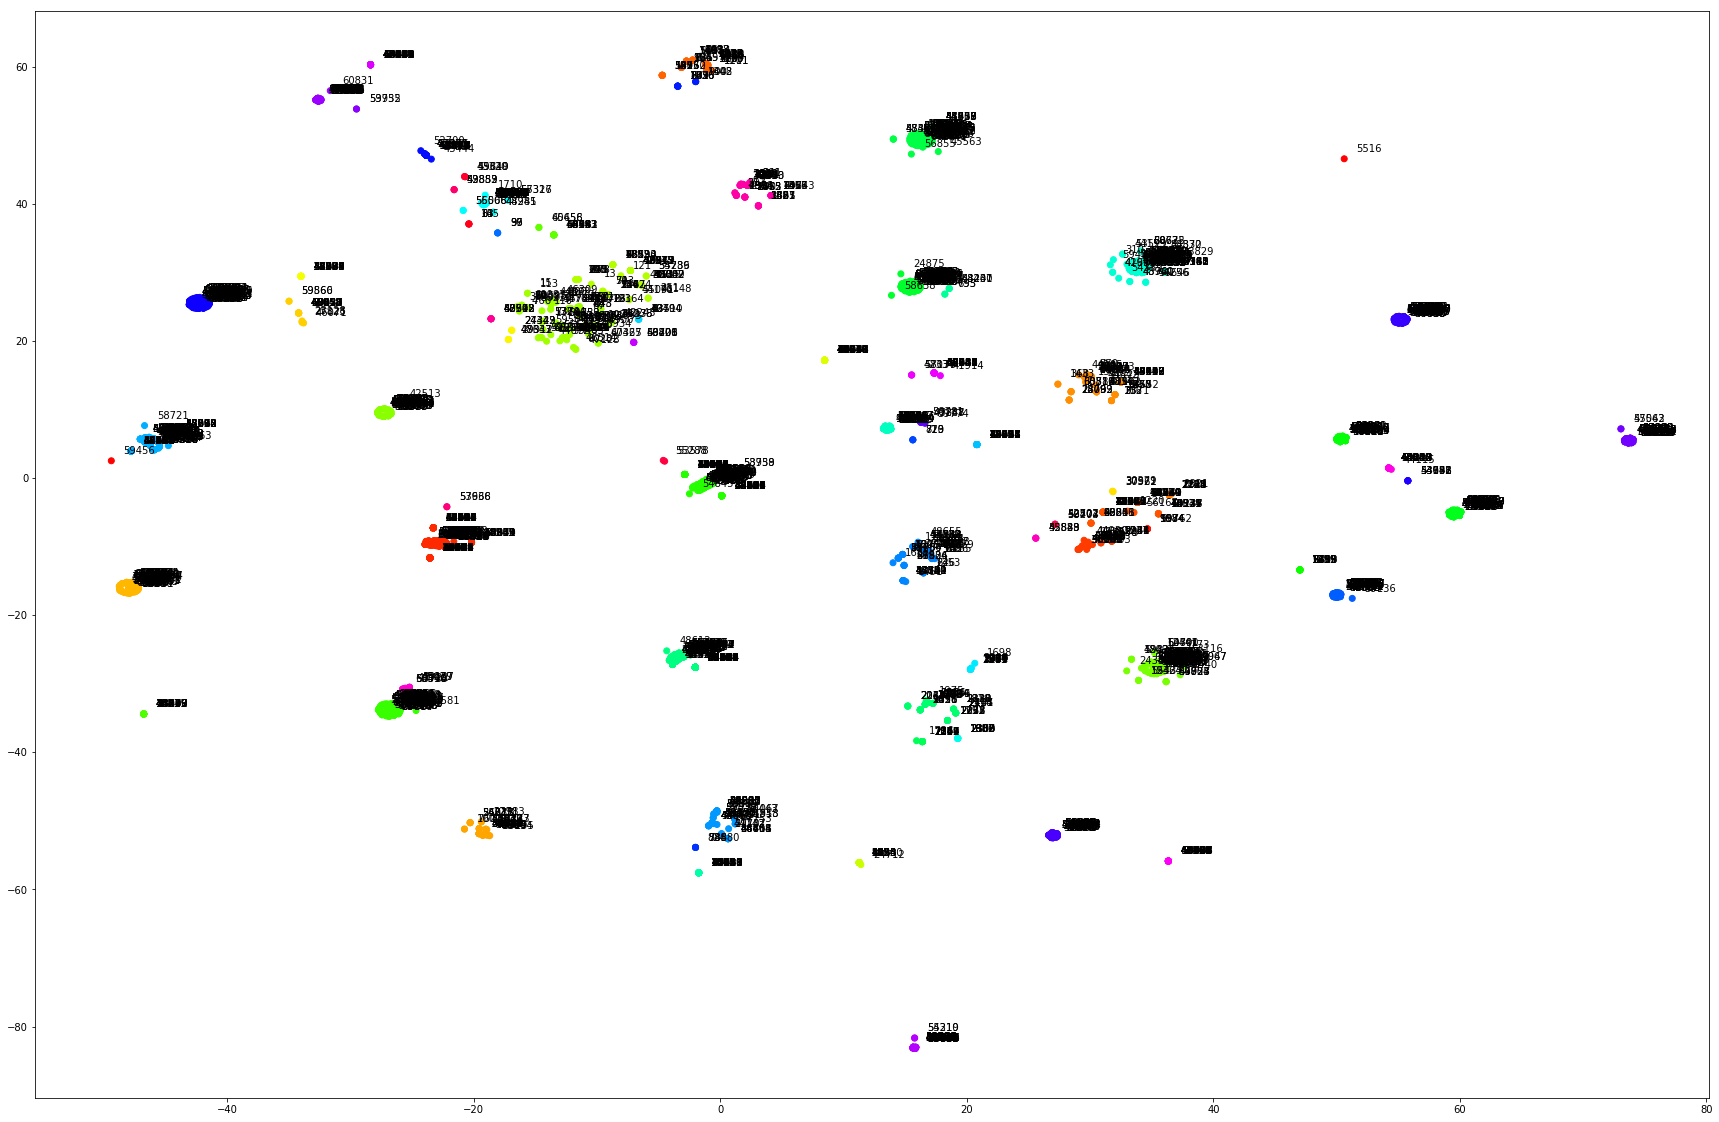

In [39]:
plt.show()

In [55]:
a=dataset_df.groupby('blocking_key')

In [61]:
a.get_group('dahua').tail(50).values

array([['www.alibaba.com', '29204',
        'hd ptz dahua 20x speed dome alarm sd6a220 hn hd ptz ip ir ptz dahua ptz speed dome ip 2mp',
        ' ', 'dahua'],
       ['www.alibaba.com', '30025',
        'dahua ir bullet 3 mega pixels hd 1080p security hd security dahua ipc hfw3300c 3mp hd network ir bullet 8” 3mp',
        ' ', 'dahua'],
       ['www.alibaba.com', '27164',
        'new security dahua cctv card ipc hdbw3202 cctv card 3g cctv secure eye cctv 8” 2mp',
        ' ', 'dahua'],
       ['www.alibaba.com', '22809',
        '2mp dh sd59220s hn ir dahua ip hd cctv ptz ip66 dahua ip hd cctv ptz dahua ptz dome ip dahua ip66 2mp',
        ' ', 'dahua'],
       ['www.alibaba.com', '25270',
        'dahua 1.3mp ccd ir ip ptz dome 18x optical zoom ir ip ptz dome outdoor dome ptz ip ptz ip network 1.3mp',
        ' ', 'dahua'],
       ['www.alibaba.com', '28442',
        'dahua dh ipc hfw5502c 5mp ir alibaba china dahua alibaba china dahua surveillance dahua 5mp 2c 5mp',
        ' ', '